# Hyperparameter optimization

This notebook explores the effect of various hyperparameters on the performance of SCINet when training on cryptocurrency data, particularly Bitcoin. We will here only address those hyperparameters that are directly accessible via the 'train_scinet' or 'preprocess' functions. Of course, we are aware that effects of different hyperparameters may correlate which means the per parameter sweep as performed here is suboptimal. That said, this approach does grant a lot of insight into the way the different hyperparameters influence the model.

First the necessary modules en scripts are imported.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
from tqdm import tqdm

cwd = os.getcwd()
BASE_DIR = os.path.dirname(os.path.dirname(cwd))

sys.path.insert(0, BASE_DIR) #add base to path for relative imports
os.chdir('../..')

### Per sample versus per column normalisation

The first thing we will investigate is the effect of the method of normalisation on the data. That is, we can either normalize every sample individually or the column as a whole. In the latter case, we apply a log function before normalising to deal with the different orders of magnitude in some features (this is the case although it is not explicitly shown here). Also, an option to skip the training (and use precomputed models instead) is available in the form of 'train'. Set it to to 'true' in case you want to train explicitly.

In [ ]:
from base.train_scinet import train_scinet
from utils.data_loading import load_data
from utils.preprocess_data import preprocess

data_format=["open","high","low","close","Volume BTC","Volume USDT","tradecount"]

X_len = 256
Y_len = 24

sampling = [True,False]

means = []
stds = []

data_test = {}

for normalize_per_sample in sampling:

    standardization_settings = {'per_sample': normalize_per_sample,
                            'leaky': False,
                            'mode': 'log', #only if per sample is false, choose from log, sqrt or lin
                            'sqrt_val': 2, #of course only if mode is sqrt
                            'total mean': [],
                            'total std': []}

    pairs = ["HUFL", "HULL", "MUFL", "MULL", "LUFL", "LULL", "OT"]
 
    data, mean ,std = load_data('Binance_BTCUSDT_minute', pairs)

    

    data_proc = preprocess(   data = data,
                        symbols = pairs,
                        data_format = data_format,
                        fraction = 1,
                        train_frac = .7,
                        val_frac = .15,
                        test_frac = .15,
                        X_LEN = X_len,
                        Y_LEN = Y_len,
                        OVERLAPPING = True,
                        STANDARDIZE = True,
                        standardization_settings = standardization_settings
                        )

    means.append(data_proc['mean'])
    stds.append(data_proc['std'])

    data_test[str(normalize_per_sample)]= {'X_test': data_proc['X_test'],'y_test_unnormalized': data_proc['y_test_unnormalized']}

    train = False
    if train:
        results = train_scinet( X_train = data_proc["X_train"].astype('float32'),
                            y_train = data_proc["y_train"].astype('float32'),
                            X_val = data_proc["X_val"].astype('float32'),
                            y_val = data_proc["y_val"].astype('float32'),
                            X_test = data_proc["X_test"].astype('float32'),
                            y_test = data_proc["y_test"].astype('float32'),
                            epochs = 7,
                            batch_size = 128,
                            X_LEN = X_len,
                            Y_LEN = [Y_len],
                            output_dim = [1],
                            selected_columns = [[0]],
                            hid_size= 16,
                            num_levels= 4,
                            kernel = 5,
                            dropout = .5,
                            loss_weights= [1],
                            learning_rate = 0.001,
                            probabilistic = False)

        results[0].save_weights(f'exp/hyperparams/saved_models/model_sample_{str(normalize_per_sample)}.h5')

        

            

In order to properly compare the performances, we should denormalize the predictions. Otherwise, the best performer will be the one where the normalisations yielded the smallest values. Here, we will only predict the first column as it shortens training considerably. In addition, since we have to denormalize we cannot fairly calculate a mae over all columns.

In [11]:
from sklearn.metrics import mean_absolute_error as mae
from base.SCINet import scinet_builder


def denormalize(x, per_sample,means,stds):

    if per_sample:
        std = stds[0][:,0]
        std = std.reshape(std.shape[0],1,1)
        std = np.stack((std for _ in range(Y_len)),axis = 1)
        std = std.reshape(std.shape[0],std.shape[1],1)
        return((x*std)[:,:,0]+means[0][:,:Y_len,0])
    else:
        x_temp = x*stds[1][0]+means[1][0]
        return(x_temp) #luckily there are no negative values in the dataset

maes = []
sampling = [True,False]
for normalize_per_sample in sampling:

    model = scinet_builder(
                    output_len=  [Y_len],
                    input_len = X_len,
                    output_dim = [1],
                    input_dim = data_proc["X_train"].shape[2],
                    selected_columns = [[0]], 
                    loss_weights = [1],
                    hid_size = 16,
                    num_levels = 4,
                    kernel = 5,
                    dropout = .5,
                    learning_rate = 0.001,)

    model.load_weights('exp/hyperparams/saved_models/model_sample_{}.h5'.format(normalize_per_sample))
    prediction = denormalize(model.predict(data_test[str(normalize_per_sample)]['X_test']),normalize_per_sample,means,stds)
    maes.append(mae(data_test[str(normalize_per_sample)]['y_test_unnormalized'][:,:,0].flatten(),prediction.flatten()))
    

print('Mae per sample = {}, mae per column = {}'.format(np.round(maes[0],3),np.round(maes[1],3)))




Building model...


/home/scinet/Jordi_folder/miniconda3/envs/ADL/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3369: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Building model...
Mae per sample = 317.308, mae per column = 719.89


As the per sample option seems to outperform its per column countepart, we will use it from here.


## Model hyperparameters

Now that we have establhed that normalising per sample is superior, we can go ahead and vary some other model hyperparameters. Particilarly, we will concern ourselves with the learning rate, hidden size and number of levels of the SCI_tree, however with few adjustments it can be used for other hyperparameters such as which columns to keep as well. We will first fix the preprocessing:

In [ ]:
from base.train_scinet import train_scinet
from utils.data_loading import load_data
from utils.preprocess_data import preprocess

data_format=["open","high","low","close","Volume BTC","Volume USDT","tradecount"]

X_len = 256
Y_len = 24


standardization_settings = {'per_sample': True,
                            'leaky': False,
                            'mode': 'log', #only if per sample is false, choose from log, sqrt or lin
                            'sqrt_val': 2, #of course only if mode is sqrt
                            'total mean': [],
                            'total std': []}

pairs = ["HUFL", "HULL", "MUFL", "MULL", "LUFL", "LULL", "OT"]
 
data, mean ,std = load_data('Binance_BTCUSDT_minute', pairs)

data_proc = preprocess(   data = data,
                        symbols = pairs,
                        data_format = data_format,
                        fraction = 1,
                        train_frac = .7,
                        val_frac = .15,
                        test_frac = .15,
                        X_LEN = X_len,
                        Y_LEN = Y_len,
                        OVERLAPPING = True,
                        STANDARDIZE = True,
                        standardization_settings = standardization_settings
                        )

We then design a loop such that the influence on a parameter of choice can be evaluated. It is possible to skip this cell and go straight to analysis of pretrained models.

In [ ]:
settings = {'hid_size': 16,
            'num_levels': 4,
            'learning_rate': 0.001}

variational_parameter = 'num_levels'
parameter_values = [1,2,4,6]

for value in parameter_values:

    settings[variational_parameter] = value

    results = train_scinet( X_train = data_proc["X_train"].astype('float32'),
                            y_train = data_proc["y_train"].astype('float32'),
                            X_val = data_proc["X_val"].astype('float32'),
                            y_val = data_proc["y_val"].astype('float32'),
                            X_test = data_proc["X_test"].astype('float32'),
                            y_test = data_proc["y_test"].astype('float32'),
                            epochs = 10,
                            batch_size = 128,
                            X_LEN = X_len,
                            Y_LEN = [Y_len],
                            output_dim = [data_proc["X_train"].shape[2]],
                            selected_columns = None,
                            hid_size= settings['hid_size'],
                            num_levels= settings['num_levels'],
                            kernel = 5,
                            dropout = .5,
                            loss_weights= [1],
                            learning_rate = settings['learning_rate'],
                            probabilistic = False)

    results[0].save_weights('exp/hyperparams/saved_models/model_{}_{}.h5'.format(variational_parameter,str(value)))


Next, we will evaluate the performance of the SCINets trained with different hyperparameters. Beware that all models here all loaded so make sure they exist.

In [44]:
from sklearn.metrics import mean_absolute_error as mae

from base.SCINet import scinet_builder
from utils.plotting import plot_barplot

settings = {'hid_size': 4,
            'num_levels': 4,
            'learning_rate': 0.001}


maes = []

variational_parameter = 'hid_size'
parameter_values = [4,16,64]

for value in parameter_values:

    settings[variational_parameter] = value

    model = scinet_builder(
                    output_len=  [Y_len],
                    input_len = X_len,
                    input_dim = data_proc["X_train"].shape[2],
                    output_dim = [data_proc["X_train"].shape[2]],
                    selected_columns = None,
                    loss_weights = [1],
                    hid_size = settings['hid_size'],
                    num_levels = settings['num_levels'],
                    kernel = 5,
                    dropout = .5,
                    learning_rate = settings['learning_rate'],)

    model.load_weights('exp/hyperparams/saved_models/model_{}_{}.h5'.format(variational_parameter,value))
    prediction = model.predict(data_proc['X_test'])
    
    print(prediction.shape,data_proc['y_test'].shape)
    maes.append(mae(data_proc['y_test'].flatten(),prediction.flatten()))
    
plot_barplot(variational_parameter, parameter_values ,maes)

Building model...


OSError: Unable to open file (unable to open file: name = 'exp/hyperparams/saved_models/model_hid_size_64.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

### How good are our models?

Although the mean absolute error is good for comparison between models with different hyperparameters, it says little about its absolute performance. In order to do such, we will take a deeper look into one model. This includes both showing sample predictions on the test set as well as a comparison to a very naive predictor. We begin with loading in the model and calculating predictions. Unfortunately, some manual adjustment have to be made per model to compile the model.

In [25]:
from base.SCINet import scinet_builder

settings = {'hid_size': 16,
            'num_levels': 4,
            'learning_rate': 0.001}

model = scinet_builder(
                    output_len=  [Y_len],
                    input_len = X_len,
                    output_dim = [data_proc["X_train"].shape[2]],
                    input_dim = data_proc["X_train"].shape[2],
                    selected_columns = None, 
                    loss_weights = [1],
                    hid_size = settings['hid_size'],
                    num_levels = settings['num_levels'],
                    kernel = 5,
                    dropout = .5,
                    learning_rate = settings['learning_rate'],)

model.load_weights('exp/hyperparams/saved_models/model_hid_size_16.h5')

predictions = model.predict(data_proc['X_test'])



Building model...


For an intuition on the quality of the predictions, we will display some made on the test set. As before, we will focus on the prediction of the opening price (the first column):

/tmp/ipykernel_23177/4224143539.py:26: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


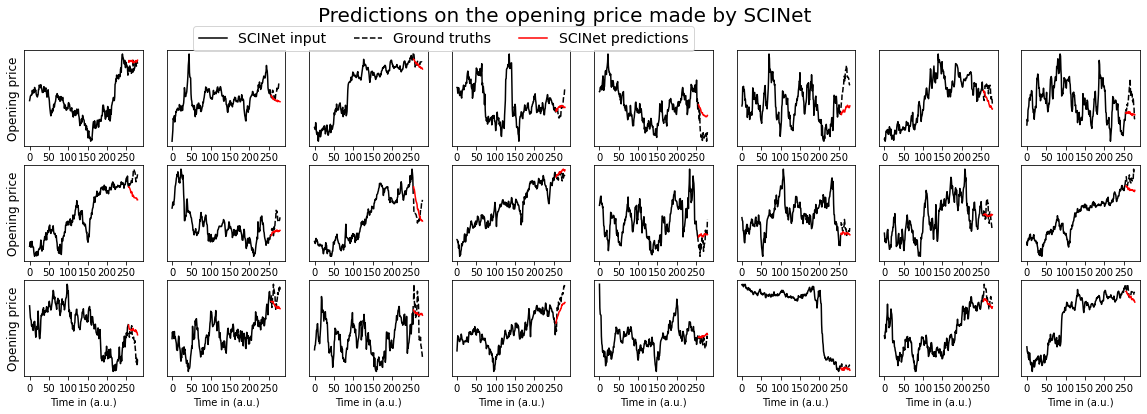

In [36]:
from utils.plotting import plot_prediction_examples

random_samples = np.random.randint(0,predictions.shape[0], size = 24)

plot_prediction_examples(random_samples, data_proc['X_test'],predictions, data_proc['y_test'])



For what a visual inspection can tell, the predictions seem reasonable. Finally then, we will take a more systematic look and compare the predictions to a very naive predictor. That is, a predictor that merely predicts 'y_train' to be the last value of 'x_train'. For this, we will plot the mean absolute error per timestep:

/home/scinet/Jordi_folder/miniconda3/envs/ADL/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3309: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if await self.run_code(code, result, async_=asy):


(7220, 24)


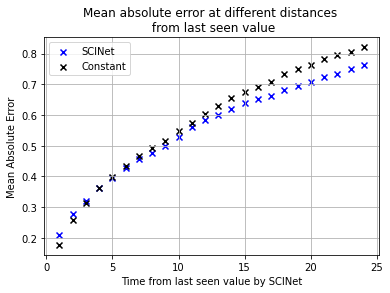

In [43]:
from utils.plotting import plot_per_timestep_mae

constant_predictions = np.stack((data_proc['X_test'][:,-1,0] for _ in range(Y_len)),axis = 1)

plot_per_timestep_mae(data_proc['y_test'],[predictions], constant_predictions, Y_len, ['SCINet'])